# New York City Taxi Fare Prediction

We are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. The evaluation metric for this competition is the root mean-squared error or RMSE. Follow the link to see the [Kaggle Competition](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/description). Note that it suggest using TensorFlow, but we will use sklearn and regression models to try and predict fare amount.

### Features
- `key` - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer. Required for submission but not for training.
- `pickup_datetime` - timestamp value indicating when the taxi ride started.
- `pickup_longitude` - float for longitude coordinate of where the taxi ride started.
- `pickup_latitude` - float for latitude coordinate of where the taxi ride started.
- `dropoff_longitude` - float for longitude coordinate of where the taxi ride ended.
- `dropoff_latitude` - float for latitude coordinate of where the taxi ride ended.
- `passenger_count` - integer indicating the number of passengers in the taxi ride.

### Label
- `fare_amount` - a float dollar amount of the cost of the taxi ride. This is the value we want to predict

# Project Overview
#### Data Exploration / Cleaning:
- Drop all missing values from data frame.
- Fixing target label by removing extreme outliers.
- Fixing passenger_count by removing extreme outliers.
- Ensure all data has realistic values and is ready for preprocessing/engineering.

#### Data Preprocessing / Feature Engineering
- Get observation year for each observation from the `pickup_datetime` column.
- Get total distance traveled for each ride (difference between latitude and longitude)
- Encode columns (create new columns, for each passenger and year value)
- Split into features and labels, drop all columns that will not be used.
- Standardize data so each column has a similar range.

#### Initial Modeling:
- Set up multiple baseline models and train to see which one to tune.
- 
- 

#### Hyperparameter Tuning:
- 
- 
- 

#### Evaluating Best Model:
- 
- 
- 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

In [16]:
nrows=2000000 # read in 2,000,000 rows from csv
data = pd.read_csv('train.csv', nrows=nrows)

data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# Data Cleaning / Exploration

- `fare_amount`: We can see that for we have negative values which should not be possible (most likely due to a recording error). We will want to drop all values that are below 0, and investigate the large gap between the 75th percentile and max value as well.

In [6]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


### Dropping Missing Values
Due to the large dataset and there only being 14 missing values, we will drop all observations that have a missing value for `dropoff_longitude` which will also eliminate all missing values in the `dropoff_latitude` feature as well.

In [3]:
data.isna().any()

key                  False
fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude     True
dropoff_latitude      True
passenger_count      False
dtype: bool

In [4]:
data['dropoff_longitude'].isna().sum()

14

In [5]:
data['dropoff_latitude'].isna().sum()

14

In [6]:
initial_len = len(data)

data.dropna(axis=0, inplace=True)

dropna_len = len(data)

print('Size before dropping missing values: {}'.format(initial_len))
print('Size after dropping missing values: {}'.format(dropna_len))

data.isna().any()

Size before dropping missing values: 2000000
Size after dropping missing values: 1999986


key                  False
fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude    False
dropoff_latitude     False
passenger_count      False
dtype: bool

### Fixing `fare_amount` distribution

We can see most of our data is focued around approximately 0-60, but our outliers habe a low of $\approx$-62 and a high of $\approx$-1273. This both of these values are very unlikely, so we want to drop all fare amounts below 2 and all fare amount above the .995 quantile (meaning the 99.5th percentile). It is safe to say most of the data is in this remaining range.

Fare amount has a min of -62.0 and a max of 1273.31


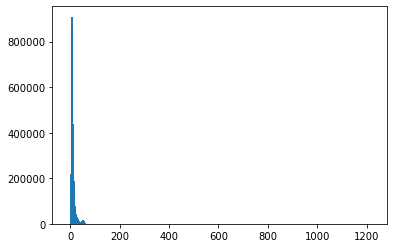

In [7]:
fare_min = data.fare_amount.min()
fare_max = data.fare_amount.max()
print('Fare amount has a min of {} and a max of {}'.format(fare_min, fare_max))
plt.hist(data['fare_amount'], bins=300)
plt.xlim([fare_min-10, fare_max+10])
plt.show()

In [17]:
data_fare_fixed = data[(data.fare_amount < data.fare_amount.quantile(.995)) & (data.fare_amount >= 2)]
print('New length: {}'.format(len(data_fare_fixed)))
data_fare_fixed.describe()

New length: 1983502


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.983502e+06,1.983502e+06,1.983502e+06,1.983490e+06,1.983490e+06,1.983502e+06
mean,1.089673e+01,-7.253308e+01,3.993535e+01,-7.253613e+01,3.993517e+01,1.683734e+00
std,8.248284e+00,1.286034e+01,7.981503e+00,1.275873e+01,1.033701e+01,1.314945e+00
min,2.000000e+00,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399212e+01,4.073515e+01,-7.399139e+01,4.073422e+01,1.000000e+00
50%,8.500000e+00,-7.398188e+01,4.075273e+01,-7.398018e+01,4.075323e+01,1.000000e+00
75%,1.250000e+01,-7.396736e+01,4.076718e+01,-7.396385e+01,4.076814e+01,2.000000e+00
max,5.731000e+01,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


Fare amount has a min of 2.0 and a max of 57.31


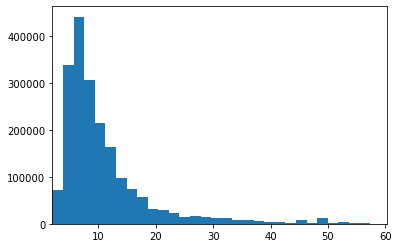

In [18]:
fare_min = data_fare_fixed.fare_amount.min()
fare_max = data_fare_fixed.fare_amount.max()
print('Fare amount has a min of {} and a max of {}'.format(fare_min, fare_max))
plt.hist(data_fare_fixed['fare_amount'], bins=30)
plt.xlim([fare_min, fare_max+3])
plt.show()

We now can see we have a right skew distribution, with a minimum of 2 and a maximum of 57.31. These values are much more likely and the data follows a much more clean distribution after dropping the values specified above. Although we lost around 10,000 observations, this is still a small amount in comparison to our total sample size. These values also could have been incorrect, which would have effected our model negatively.

### Fixing `passenger_count` distribution

We also noticed from the summary statistics table that passenger count has a max value of 208. It is very unlikely that there were this many passenger (most likely due to a recording error). We will want to drop the obsevations with extremly large passenger counts since this will negatively impact our model. From checking the data, it looks like 208 is the only value above 7 in the passenger column, so we will drop just the single observation.

In [19]:
data_fare_fixed['passenger_count'].value_counts()

1      1372310
2       292891
5       140559
3        86908
4        42216
6        41501
0         7116
208          1
Name: passenger_count, dtype: int64

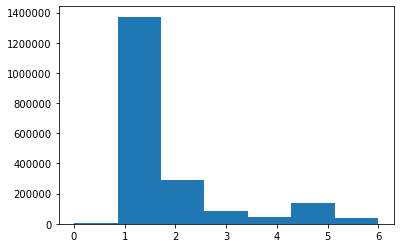

In [20]:
data_p_fixed = data_fare_fixed[data_fare_fixed['passenger_count'] < 7]
plt.hist(data_p_fixed['passenger_count'], bins=7);

In [21]:
data_p_fixed.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.983501e+06,1.983501e+06,1.983501e+06,1.983489e+06,1.983489e+06,1.983501e+06
mean,1.089674e+01,-7.253311e+01,3.993537e+01,-7.253616e+01,3.993519e+01,1.683630e+00
std,8.248284e+00,1.286024e+01,7.981454e+00,1.275863e+01,1.033697e+01,1.306759e+00
min,2.000000e+00,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399212e+01,4.073515e+01,-7.399139e+01,4.073422e+01,1.000000e+00
50%,8.500000e+00,-7.398188e+01,4.075273e+01,-7.398018e+01,4.075323e+01,1.000000e+00
75%,1.250000e+01,-7.396736e+01,4.076718e+01,-7.396385e+01,4.076814e+01,2.000000e+00
max,5.731000e+01,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,6.000000e+00


In [22]:
data_p_fixed.to_csv('cleaned_train_data.csv', index=False) # saved cleaned data for future use

In [55]:
df = pd.read_csv('cleaned_train_data.csv') # read in cleaned data to new data frame
df.head() 

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# Data Preprocessing / Feature Engineering

### Get observation year
We want to extract the year from the `pickup_datetime` column. This could have influence on the fare price given the year in which the ride was. We can see our observations range from 2009-2015 with a mostly even class balance (except for 2015).

In [56]:
df['year'] = df['pickup_datetime'].apply(lambda x: x.split(' ')[0].split('-')[0])

In [57]:
df.year.value_counts()

2012    321586
2011    317245
2009    308045
2013    307706
2010    300698
2014    291583
2015    136638
Name: year, dtype: int64

### Get distance traveled
We want to take the difference between the pickup and dropoff latitude/longitude to find the total distance traveled during the taxi ride. My hypothesis is that this will have the highest correlation with fare price (finding a distance to price ratio).

In [58]:
df['longitude_distance'] = np.abs(df['pickup_longitude'] - df['dropoff_longitude'])
df['latitude_distance'] = np.abs(df['pickup_latitude'] - df['dropoff_latitude'])

In [59]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,longitude_distance,latitude_distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009,0.002701,0.009041
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010,0.036780,0.070701
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011,0.008504,0.010708
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012,0.004437,0.024949
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010,0.011440,0.015754


### Encoding Data
We want to use One-Hot Encoding for our data before we normalize it. We will create seperate columns for each year and passenger count.

In [79]:
X = df.drop(['key', 'fare_amount', 'pickup_datetime'], axis=1) # Get numerical data only (input for our model)
y = df['fare_amount'] # labels

In [80]:
year_encoded = pd.get_dummies(X['year'])
year_encoded.columns = ['year_' + str(col) for col in year_encoded.columns]
X = pd.concat([X, year_encoded], axis=1).drop('year', axis=1)

passenger_encoded = pd.get_dummies(X['passenger_count'])
passenger_encoded.columns = ['passengers_' + str(col) for col in passenger_encoded.columns]
X = pd.concat([X, passenger_encoded], axis=1).drop('passenger_count', axis=1)

X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,longitude_distance,latitude_distance,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,passengers_0,passengers_1,passengers_2,passengers_3,passengers_4,passengers_5,passengers_6
0,-73.844311,40.721319,-73.841610,40.712278,0.002701,0.009041,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,-74.016048,40.711303,-73.979268,40.782004,0.036780,0.070701,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,-73.982738,40.761270,-73.991242,40.750562,0.008504,0.010708,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,-73.987130,40.733143,-73.991567,40.758092,0.004437,0.024949,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,-73.968095,40.768008,-73.956655,40.783762,0.011440,0.015754,0,1,0,0,0,0,0,0,1,0,0,0,0,0


### Standardizing Data

We want to standardize our data so that each column will have equals ranges. Since our evluation will be on the RMSE (distance based metric) we want to scale our features.

In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

# Initial Modeling

In [87]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor